In [20]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification,AdamW,BertForSequenceClassification,DistilBertModel
import torch
from torch.utils.data import DataLoader
import pickle
from sklearn.model_selection import train_test_split
import numpy as np
import tqdm
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import pandas as pd
import torch.nn as nn
from transformers import BartTokenizer, BartForSequenceClassification,BertTokenizer
%matplotlib inline
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix

In [2]:
!nvidia-smi

Wed Jan 13 09:52:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:04:00.0 Off |                    0 |
| N/A   32C    P0    24W / 250W |      8MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   

In [3]:
!kill -9 57000

/bin/bash: line 0: kill: (57000) - No such process


## Functions

In [21]:
def accuracy(out_logits,labels):
    labels = labels.detach().cpu().numpy()
    predicted = out_logits.detach().cpu().numpy()
    predicted = np.argmax(predicted,axis=1).reshape(labels.shape)
    return np.mean(labels == predicted)

def val_params(model,val_loader):
    temp = model.eval()
    num_batches = 0
    loss_sum = 0
    accuracy_sum =0
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        with torch.no_grad():
            outputs = model.forward(input_ids, attention_mask=attention_mask,labels=labels)
        target = torch.eye(len(id2lab))[labels.detach().cpu()].to(device)
        #loss_mse = mse_criterion(outputs.logits,target)
        loss = criterion(outputs.logits.view(-1,len(id2lab)),labels.view(-1))
        loss = loss 
        loss_sum += loss.item()
        accuracy_sum += accuracy(outputs.logits,labels)
        num_batches +=1
    return loss_sum/num_batches,accuracy_sum/num_batches

class EmpathyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues,
                         figsize = (10,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm =np.round(cm,2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.rcParams["figure.figsize"] = figsize
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    
    

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def get_dataloader(text,tokenizer,labels=None,batch_size=32):
    if labels is None:
        labels = [0]*len(text)
    encodings = tokenizer(text,truncation=True, padding='longest', return_tensors="pt")
    dataset = EmpathyDataset(encodings,labels)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return data_loader
    

## Setup

In [22]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [27]:
model_names = [
    'facebook/bart-large',
    'bert-base-uncased',
    "../model/BART_empathy_15_classes/",
    "../model/BERT_empathy_15_classes/",
    "../model/BART_empathy_14_classes/",
    "../model/BART_empathy_14_classes_weighted_loss/"
]

In [28]:
Model = BartForSequenceClassification
model_name = model_names[0]
ModelTokenizer = BartTokenizer
path_to_save = "../model/BART_14_weight_anxious/" 

In [3]:
df = pickle.load(open("../data/empathy_cls_df.p","rb"))

In [6]:
!pwd

/home/gsinha1/Documents/empathy_recognition/src


In [ ]:
gsinha1@melco.cs.ualberta.ca:/home/gsinha1/Documents/empathy_recognition/data/empathy_cls_df.p

## Data preprocessing


In [23]:
df = pickle.load(open("../data/empathy_cls_valid_df.p","rb"))
id_to_lab = list(set(df.context))
lab_to_id = { lab : idx  for idx,lab in enumerate(id_to_lab)}
grouped_emotions =[
    ['annoyed','angry','disgusted','furious'],
    ['embarrassed','ashamed','guilty'],
    ['afraid','terrified','anxious','apprehensive'],
    ['nostalgic','sentimental'],
    ['hopeful','anticipating'],
    #[],
    ['lonely','sad','devastated','disappointed'],
    ['joyful','excited','content','proud'],
    ['faithful','trusting'],
    ['prepared','confident'],
    ['caring'],
    ['grateful'],
    ['impressed'],
    ['jealous'],
    ['surprised']
    #['no_emo']
  ]
id2lab = [
    'angry',
    'ashamed',
    'afraid',
    'sentimental',
    'hopeful',
    #'apprehensive',
    'sad',
    'happy',
    'faithful',
    'confident',
    'caring',
    'grateful',
    'impressed',
    'jealous',
    'surprised'
    #'no_emo'
]

full_lab2id = {}
for emo in id_to_lab:
    for i,lst in enumerate(grouped_emotions):
        if emo in lst:
            full_lab2id[emo]=i

lab2id = { emo:i for i,emo in enumerate(id2lab)}

In [9]:
y = [ full_lab2id[lab] for lab in list(df.context)]
x = list(map(lambda x:x.replace('_comma_',','),list(df.prompt)))

In [10]:
# pd.DataFrame({
#     'tar':list(map(lambda x:id2lab[x],y_val)),
#     'lab':list(map(lambda x:id2lab[x],y_val))
# }).groupby('tar').agg('count')

In [11]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.99, random_state=42)

In [12]:
counts = [0]*len(id2lab)
for idx in y_train:
    counts[idx]+=1
weights = [100/count for count in counts]

ZeroDivisionError: division by zero

In [20]:
weights

NameError: name 'weights' is not defined

In [21]:
pd.set_option( "display.max_columns", None)
df=pd.DataFrame({
    'x':x_val,
    'y':list(map(lambda x:id2lab[x],y_val))
})
df

,x,y
0,I was disappointed with the score i got on my ...,sad
1,won $100 on a scratch off card,surprised
2,My sister's cat got sick and had to be put dow...,sad
3,I finally got all of my work done for the day....,happy
4,Yesterday my brother did a back flip off the r...,impressed
...,...,...
2731,I am learning how to do day trading and did my...,confident
2732,I got an phone call from someone I used to kno...,afraid
2733,As soon as I arrived at the bus stop and the b...,happy
2734,Earlier this week when I got my yearly review ...,happy


## Tokenization

In [32]:
tokenizer = ModelTokenizer.from_pretrained(model_name)

In [14]:
train_encodings = tokenizer(x_train,truncation=True, padding='longest', return_tensors="pt")
val_encodings = tokenizer(x_val,truncation=True, padding='longest', return_tensors="pt")

In [15]:
train_dataset = EmpathyDataset(train_encodings,y_train)
val_dataset = EmpathyDataset(val_encodings,y_val)

In [16]:
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Model creation

In [21]:
class EmpathyClassificationModel(nn.Module):
    def __init__(self,device):
        super(EmpathyClassificationModel, self).__init__()
        self.bert_pt = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)
        self.dense = nn.Linear(768,768).to(device)
        self.fc1 = nn.Linear(768,256).to(device)
        self.fc2 = nn.Linear(256,32).to(device)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self,input_ids,attention_mask):
        x = self.bert_pt(input_ids.long(), attention_mask=attention_mask)
        x = self.tanh(self.dense(x.last_hidden_state[:,0]))
        x = self.dropout(x)
        x = self.tanh(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
#ecm = EmpathyClassificationModel(device)

In [25]:
len(id2lab)

15

In [26]:
ecm = Model.from_pretrained(model_name,num_labels=len(id2lab)).to(device)

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large and are newly initialized: ['classification_head.out_proj.bias', 'classification_head.dense.weight', 'classification_head.out_proj.weight', 'classification_head.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training Model

In [27]:
optim = AdamW(ecm.parameters(), lr=1e-5)
weight=torch.tensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=weight)
mse_criterion = nn.MSELoss()
EPOCHS=10
prev_val_acc = -1
temp = ecm.train()
for epoch in range(EPOCHS):
    loss_sum = 0
    accuracy_sum = 0
    num_batch = 0
    pbar = tqdm.tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = ecm(input_ids, attention_mask=attention_mask,labels=labels)
        target = torch.eye(len(id2lab))[labels.detach().cpu()].to(device)
        #loss_mse = mse_criterion(outputs.logits,target)
        loss = criterion(outputs.logits.view(-1,len(id2lab)),labels.view(-1))
        loss = loss 
        #loss = outputs[0]
        loss.backward()
        optim.step()
        loss_sum += loss.item()
        accuracy_sum += accuracy(outputs.logits,labels)
        num_batch+=1
        pbar.set_description("Epoch: %s, Train loss: %f, Train accuracy: %f"%(epoch,loss_sum/num_batch,accuracy_sum/num_batch))
    
    val_metric = val_params(ecm,val_loader)
    sys.stdout.write("         Val loss: %f, Val accuracy: %f"%val_metric)
    sys.stdout.flush()
    
    #Breaking criteria
    if prev_val_acc > val_metric[1]:
        break
    
    prev_val_acc = val_metric[1]
    
    #saving model checkpoint
    ecm.save_pretrained(path_to_save)
    tokenizer.save_pretrained(path_to_save)
    


Epoch: 0, Train loss: 1.128587, Train accuracy: 0.656852: 100%|██████████| 519/519 [08:55<00:00,  1.03s/it]


         Val loss: 0.712509, Val accuracy: 0.774546

Epoch: 1, Train loss: 0.565487, Train accuracy: 0.806118: 100%|██████████| 519/519 [08:46<00:00,  1.01s/it]


         Val loss: 0.666084, Val accuracy: 0.775797

Epoch: 2, Train loss: 0.360519, Train accuracy: 0.870063: 100%|██████████| 519/519 [08:44<00:00,  1.01s/it]


         Val loss: 0.673408, Val accuracy: 0.782805

Epoch: 3, Train loss: 0.218815, Train accuracy: 0.919557: 100%|██████████| 519/519 [08:41<00:00,  1.00s/it]


         Val loss: 0.735134, Val accuracy: 0.789706

Epoch: 4, Train loss: 0.129855, Train accuracy: 0.951168: 100%|██████████| 519/519 [08:44<00:00,  1.01s/it]


         Val loss: 0.785662, Val accuracy: 0.792888

Epoch: 5, Train loss: 0.072455, Train accuracy: 0.973206: 100%|██████████| 519/519 [08:46<00:00,  1.01s/it]


         Val loss: 0.953941, Val accuracy: 0.787114

In [35]:
#model.save_pretrained("path_to_save")
#tokenizer.save_pretrained("path_to_save")
ecm.save_pretrained('../model/BART_empathy_14_classes_weighted_loss_copy/')

## Evaluations

In [29]:
def get_model_output(data_loader):
    text = []
    y_true = []
    y_pred = []
    logits = []
    t=ecm.eval()
    pbar = tqdm.tqdm(data_loader)
    for data in pbar:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['labels'].to(device)
        output = ecm(input_ids, attention_mask=attention_mask)
        pred_labels = torch.argmax(output.logits,dim=1).detach().cpu().numpy().tolist()
        labels_numpy = labels.detach().cpu().numpy().tolist()
        y_true = y_true + labels_numpy
        y_pred = y_pred + pred_labels
        logits = torch.max(output.logits,dim=1).values.tolist()+logits
        text = text + list(map( lambda x:tokenizer.decode(x,skip_special_tokens=True),input_ids ))

    y_true=list(map(lambda x: id2lab[x],y_true))
    y_pred = list(map(lambda x: id2lab[x],y_pred))
    pred_out = text,y_true,y_pred,logits
    df = pd.DataFrame({
        'Text': pred_out[0],
        'Target':pred_out[1],
        'Predicted':pred_out[2],
        'logits':pred_out[3]
    })
    return df



In [30]:
ecm = Model.from_pretrained(path_to_save).to(device)

In [24]:
pred_out_df = get_model_output(val_loader)


100%|██████████| 184/184 [01:05<00:00,  2.79it/s]


In [25]:
pickle.dump(pred_out_df,open( "../data/val_data_15_w_no_emo_df.p", "wb" ))

Normalized confusion matrix


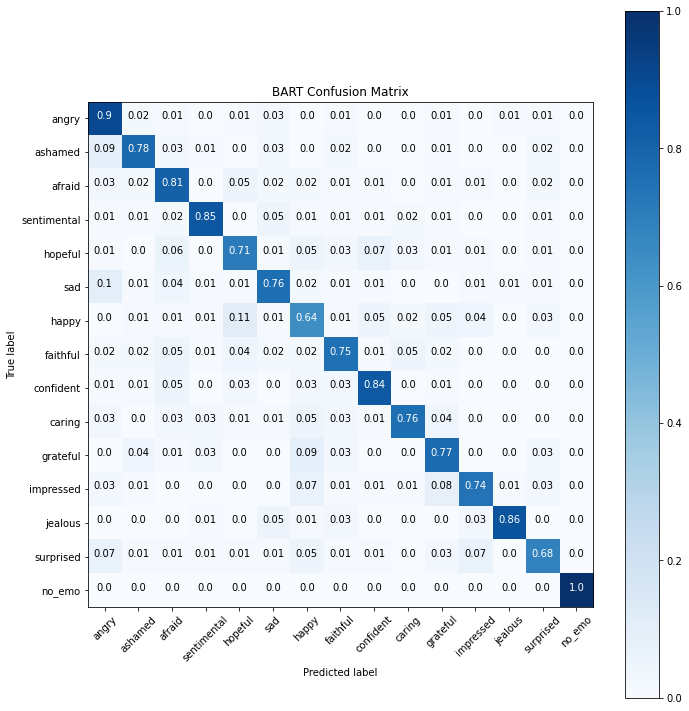

In [26]:
cm = confusion_matrix(pred_out_df['Target'],pred_out_df['Predicted'],labels=id2lab)
plot_confusion_matrix(cm,id2lab,normalize=True,title="BART Confusion Matrix")

In [27]:
f1 = f1_score(pred_out_df['Target'],pred_out_df['Predicted'],average=None)
np.mean(f1)

0.780458335348673

In [28]:
f1

array([0.81230769, 0.83505155, 0.81348315, 0.72727273, 0.8238342 ,
       0.72874494, 0.63736264, 0.71090047, 0.64896755, 0.71090047,
       0.88235294, 0.99746835, 0.80945347, 0.85448916, 0.71428571])

In [29]:
accuracy_score(pred_out_df['Target'],pred_out_df['Predicted'])

0.792774369461486

In [33]:
texts = [
    'How are you',
    'I am going out tomorrow to get some groceries',
    "I drink milk everyday",
    "are you a boy",
    "Do you know me",
    "I went to market yesterday to purchase food",
    "Do I have a better chance to get this job",
    "Can I go outside",
    "you are annoyning me, I am too tired, please go away",
    "I failed my exam",
    "I broke my leg",
    "Are you mad? why are you repeating the same thing again and again",
    "I am going for sleep now",
    "My dog died.What should I do?",
    "I won the lottery yesterday",
    "Why the hell are you irritating me?",
    "Why are you standing here?",
    "I like to go out after eating",
    "I am doing good",
    "Its my son's birthday tomorrow",
    "Where is your better half"
]
tokens = tokenizer(texts,truncation=True, padding='longest', return_tensors="pt")
input_ids = tokens['input_ids'].to(device)
attention_mask = tokens["attention_mask"].to(device)
output = ecm(input_ids, attention_mask=attention_mask)
pred_labels = torch.argmax(output.logits,dim=1).detach().cpu().numpy()
df = pd.DataFrame({
    "text":texts,
    "labels":list(map(lambda x: id2lab[x],pred_labels)),
    "logits":torch.max(output.logits,dim=1).values.tolist()
    
})
df

,text,labels,logits
0,How are you,happy,2.291057
1,I am going out tomorrow to get some groceries,confident,5.117095
2,I drink milk everyday,faithful,3.407278
3,are you a boy,ashamed,1.473150
4,Do you know me,sentimental,2.269664
5,I went to market yesterday to purchase food,confident,3.923620
6,Do I have a better chance to get this job,confident,4.660431
7,Can I go outside,afraid,4.472110
8,"you are annoyning me, I am too tired, please g...",angry,4.785026
9,I failed my exam,ashamed,4.504467


In [29]:
x = np.array(pickle.load(open("../data/x_train.p","rb")))
y = np.array(pickle.load(open("../data/y_train.p","rb")))
no_ques = []
ques = []
x0 = x[y==0]
for text in x0:
    if text[-1]!='?':
        no_ques.append(text)
    else:
        ques.append(text)

In [30]:
ques_df = pd.DataFrame({
    'texts':ques
})
ques_df.head(10)

,texts
0,"Lucy , where are you going ?"
1,What do you recycle in your plant ?
2,Where's your better half ?
3,Then do I have the chance to get this job ?
4,"No , it isn't mine . I blundered upon it under..."
5,"I bought a pair of trousers last year , which ..."
6,Business is booming . I understand you want to...
7,"It's very confusing in here , isn't it ?"
8,Perhaps you should exercise more . Why don't y...
9,"Wonderland Travel , may I help you ?"


In [27]:
mn ='../model/BART_13_no_weight_anxious/'
ecm = Model.from_pretrained(mn).to(device)
tokenizer = ModelTokenizer.from_pretrained(mn)

In [31]:
data_loader = get_dataloader(ques,tokenizer,batch_size=8)
pred_no_ques_df = get_model_output(data_loader)

100%|██████████| 878/878 [02:00<00:00,  7.30it/s]


In [32]:
pickle.dump(pred_no_ques_df,open( "../data/gpt2_14_w_ques_df.p", "wb" ))

In [ ]:
pd.set_option('display.max_colwidth', 0)
pred_no_ques_df.head(50)

In [51]:
pickle.dump(pred_no_ques_df,open( "../data/gpt2_14_rms_weighted_df.p", "wb" ))

In [28]:
!nvidia-smi

Wed Jan  6 13:57:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Graphics Device     Off  | 00000000:41:00.0 Off |                    0 |
| N/A   41C    P0    37W / 250W |  22488MiB / 32502MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Graphics Device     Off  | 00000000:C1:00.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |     10MiB / 32502MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [ ]:
!kill -9 54372

[Text(0.5, 1.0, 'Frequency Histogram'), Text(0, 0.5, 'Frequency')]

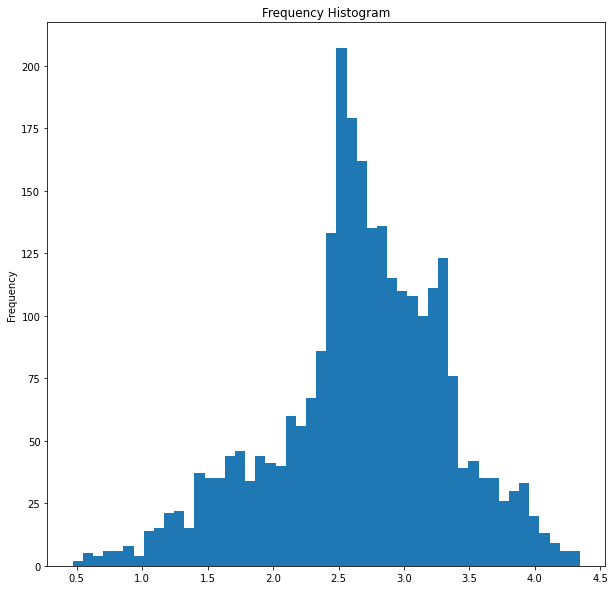

In [45]:
# Plot Histogram on x
x = np.array(pred_out_df.logits)
plt.hist(x, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency')

[Text(0.5, 1.0, 'Frequency Histogram'), Text(0, 0.5, 'Frequency')]

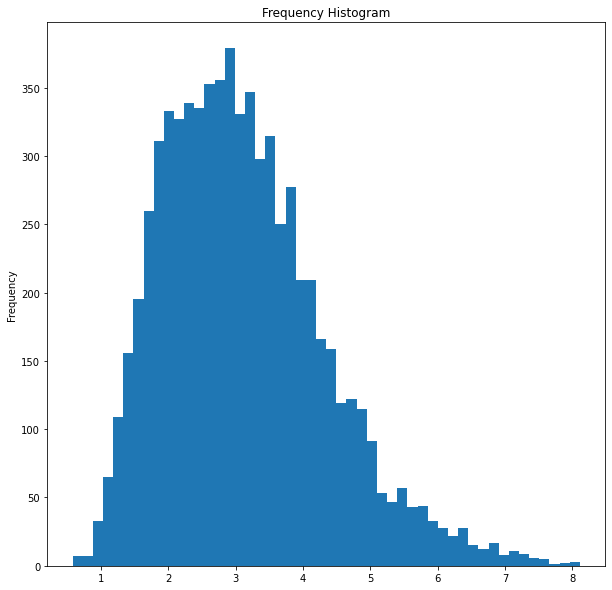

In [33]:
plt.rcParams["figure.figsize"] = (10,10)
x = np.array(pred_no_ques_df.logits)
plt.hist(x, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency')

In [34]:
np.mean(pred_no_ques_df.logits<4.5)

0.8743052586575459

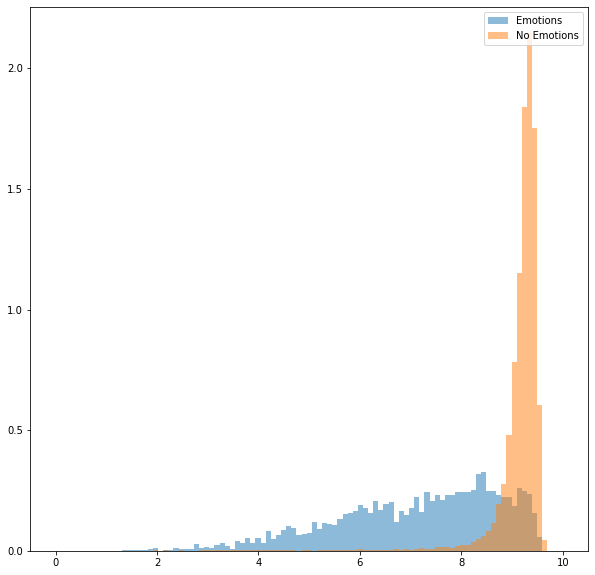

In [38]:
bins = np.linspace(0, 10, 100)

plt.hist(pred_out_df.logits, bins, alpha=0.5, label='Emotions',density= True)
plt.hist(pred_no_ques_df.logits,bins, alpha=0.5, label='No Emotions',density= True)
#plt.axvline(x=results.query('Model==@mod_name')['Threshold'].item(), c = 'red',ls='--',animated=True,label ='Threshold')
plt.legend(loc='upper right')
plt.show()

In [57]:
np.quantile(x,0.60)

1.9990789651870728

In [58]:
np.mean(x)

1.85876031765834

In [59]:
y=np.array(pred_out_df.logits)

In [61]:
np.quantile(y,0.1)

1.7142771482467651

In [62]:
np.percentile(x,np.quantile(y,0.1))

0.6456816422209044

In [6]:
x = torch.tensor([22,4,30,9,14])

In [7]:
x

tensor([22,  4, 30,  9, 14])

In [12]:
y = x.sort(descending=True)

In [13]:
y

torch.return_types.sort(
values=tensor([30, 22, 14,  9,  4]),
indices=tensor([2, 0, 4, 3, 1]))

In [17]:
y[0].tolist()

[30, 22, 14, 9, 4]

In [19]:
y[1][0].item()

2